<a href="https://colab.research.google.com/github/paxF3E/Image-Classification-by-Fedarated-Learning/blob/main/Img_Clsf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall --yes tensorboard tb-nightly

!pip install --quiet --upgrade tensorflow-federated-nightly
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

import nest_asyncio
nest_asyncio.apply()

# env setup

Found existing installation: tensorboard 2.6.0
Uninstalling tensorboard-2.6.0:
  Successfully uninstalled tensorboard-2.6.0
     |████████████████████████████████| 742 kB 5.1 MB/s 
     |████████████████████████████████| 4.2 MB 37.4 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 251 kB 40.8 MB/s 
     |████████████████████████████████| 489.8 MB 1.6 kB/s 
     |████████████████████████████████| 121 kB 49.8 MB/s 
     |████████████████████████████████| 172 kB 43.5 MB/s 
     |████████████████████████████████| 4.0 MB 34.5 MB/s 
     |████████████████████████████████| 2.1 MB 32.6 MB/s 
     |████████████████████████████████| 5.8 MB 43.3 MB/s 
     |████████████████████████████████| 463 kB 50.9 MB/s 
     |████████████████████████████████| 13.4 MB 236 kB/s 
     |████████████████████████████████| 1.3 MB 36.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

In [4]:
%load_ext tensorboard
# tb load

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()
# imports

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

In [5]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
# loading data

In [7]:
len(emnist_train.client_ids)

3383

In [8]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [9]:
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])
example_element = next(iter(example_dataset))
example_element['label'].numpy()

## allows to iterate over client ids in this case
## FL doesnt deal in client ids, just the data subsets

1

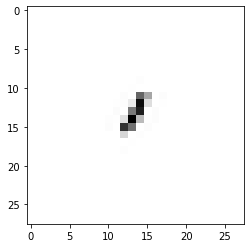

In [12]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

# visualisation

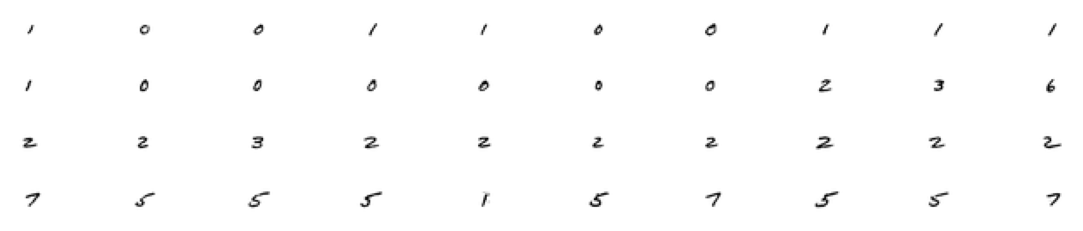

In [13]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1


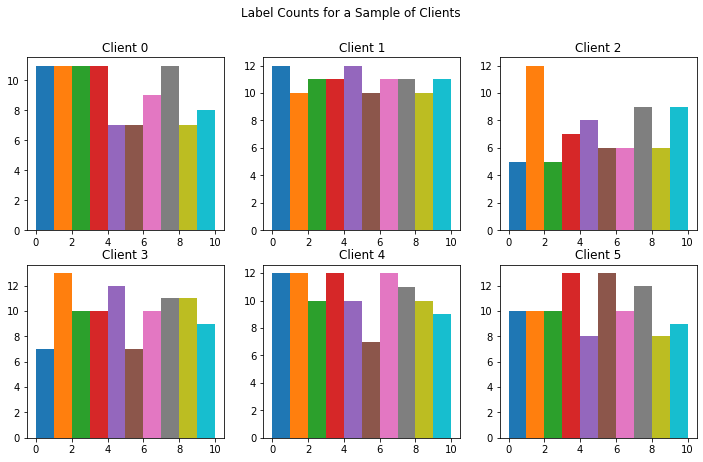

In [14]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


In [ ]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')


In [ ]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch


In [ ]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]


In [ ]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))


In [ ]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [ ]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))


In [ ]:
str(iterative_process.initialize.type_signature)


In [ ]:
state = iterative_process.initialize()


In [ ]:
# SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS


In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))


In [ ]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))


In [ ]:
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()


In [ ]:
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    for name, value in metrics['train'].items():
      tf.summary.scalar(name, value, step=round_num)


In [ ]:
!ls {logdir}
%tensorboard --logdir {logdir} --port=0
